### *A* | *B* Testing Using MCMC and PyMC3

Probably not a good choice for now. Development for Theano, PyMC3's backend, came to end this past October. PyMC devs are exploring other backends (PyTorch, MXNet, TensorFlow/probability), but so far there is only one script testing a backend (PyTorch) in the the PyMC4 prototype repo.

https://github.com/pymc-devs/pymc3/issues/1650

Stan (via PyStan or RStan) or the greta R package (with TensorFlow backend) may be better long-run probablistic programming / Bayesian modeling toolkits. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
#figsize(20, 10)

import pymc3 as pm
import numpy as np
import scipy.stats as stats
from scipy.optimize import fmin_powell

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

In [3]:
# Set (unobserved) true population means for control and treatment
true_pA = 0.05
true_pB = 0.055

# Number of observations for each group
nA = 20000
nB = 20000

# Generate some observations
observations_A = stats.bernoulli.rvs(true_pA, size=nA)
observations_B = stats.bernoulli.rvs(true_pB, size=nB)

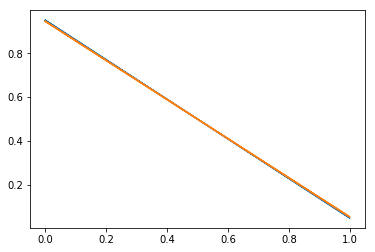

In [4]:
plt.plot(observations_A, stats.bernoulli.pmf(observations_A, true_pA))
plt.plot(observations_B, stats.bernoulli.pmf(observations_B, true_pB))

In [5]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.05195
0.05655


In [6]:
# Assume Uniform priors for pA and pB

with pm.Model() as model:
    pA = pm.Uniform("pA", 0, 1)
    pB = pm.Uniform("pB", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest
    delta = pm.Deterministic("delta", pB - pA)

    
    # Set of observations, in this case we have two observation datasets
    obs_A = pm.Bernoulli("obs_A", pA, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", pB, observed=observations_B)

    # Use Powell's Method from scipy.optimize for MAP estimation
    start = pm.find_MAP(fmin=fmin_powell)
    step = pm.Metropolis()
    trace = pm.sample(500000, step=step, start=start)
    # Toss burn in samples

/usr/local/lib/python3.6/site-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -8,431.7:   1%|          | 40/5000 [00:00<00:02, 1878.83it/s]

Optimization terminated successfully.
         Current function value: 8431.692274
         Iterations: 2
         Function evaluations: 48


logp = -8,431.7:   1%|          | 48/5000 [00:01<01:49, 45.33it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [pB_interval__]
>Metropolis: [pA_interval__]
100%|██████████| 500500/500500 [06:29<00:00, 1285.83it/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110e32b38>,
      dtype=object)

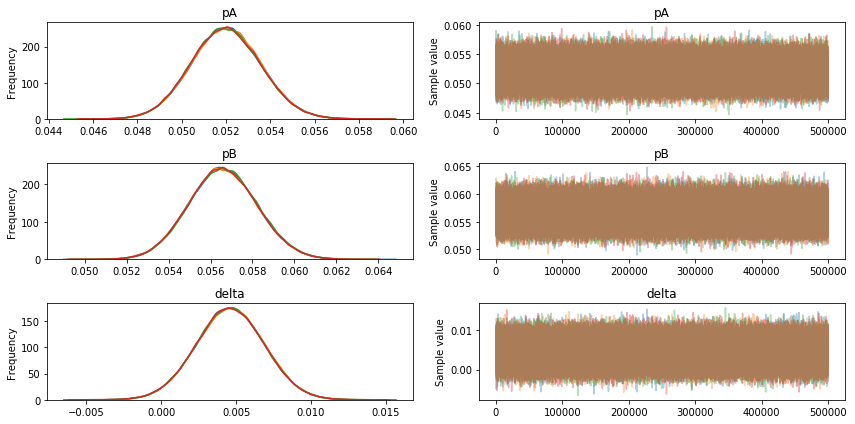

In [7]:
# Examine sample raw convergence
pm.plots.traceplot(trace)

In [8]:
pm.stats.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pA,0.051995,0.001572,0.000002,0.048957,0.055118,417895.0,1.000009
pB,0.056596,0.001633,0.000002,0.053374,0.059770,417900.0,1.000000
delta,0.004601,0.002265,0.000003,0.000145,0.009020,416330.0,1.000007


In [9]:
# Toss burn in samples
burned_trace=trace[5000:]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11405d2b0>,
      dtype=object)

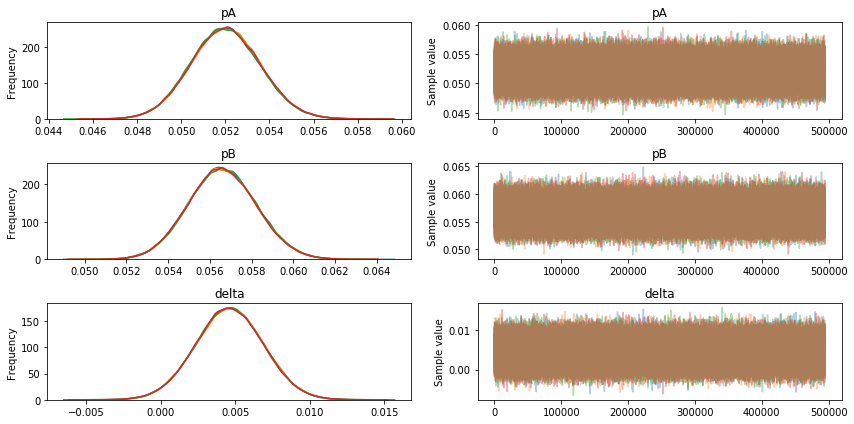

In [10]:
# Examine sample convergence after discarding burn in samples
pm.plots.traceplot(burned_trace)

In [11]:
pm.stats.summary(burned_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pA,0.051995,0.001572,0.000002,0.048966,0.055124,414839.0,1.000010
pB,0.056596,0.001632,0.000002,0.053394,0.059788,415880.0,1.000000
delta,0.004601,0.002264,0.000003,0.000144,0.009017,414299.0,1.000007


In [12]:
pA_samples = burned_trace["pA"]
pB_samples = burned_trace["pB"]
delta_samples = burned_trace["delta"]

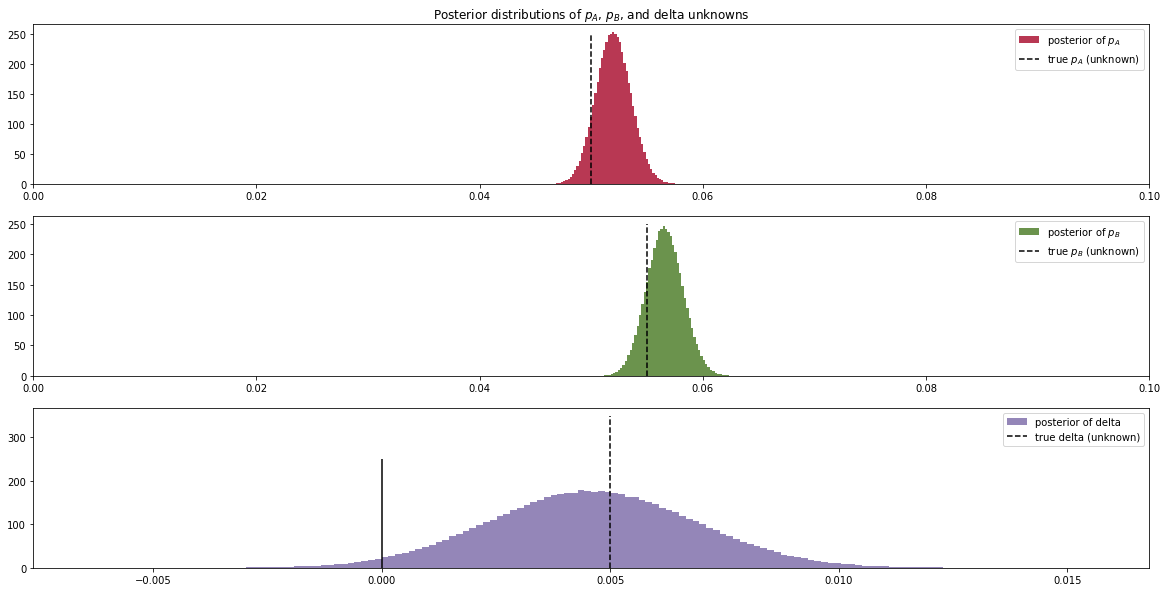

In [13]:
# Histogram of posteriors

figsize(20, 10)

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(pA_samples, histtype='stepfilled', bins=75, alpha=0.80,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_pA, 0, 250, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(pB_samples, histtype='stepfilled', bins=75, alpha=0.80,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_pB, 0, 250, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)

plt.hist(delta_samples, histtype='stepfilled', bins=150, alpha=0.80,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_pB - true_pA, 0, 350, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 250, color="black", alpha=1)
plt.legend(loc="upper right");

In [14]:
# Probability that treatment B is better than control A

print("Probability treatment B is WORSE than control A: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability treatment B is BETTER than control A: %.3f" % \
    np.mean(delta_samples > 0))

Probability site B is WORSE than site A: 0.021
Probability site B is BETTER than site A: 0.979


In [15]:
# Credible Interval, alpha = .05

pm.stats.hpd(delta_samples, alpha=0.05)

array([0.00014428, 0.00901744])